In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm  # progress meter

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(os.environ.get("PWD"))  # change working directory to project directory
from src.helper.helper_sklearn_plotting import plot_feature_importances
from src.helper.helper_mnist_download import get_mnist_dataset

Duplicate key in file '/Users/martin/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
data, labels = get_mnist_dataset()

train-images-idx3-ubyte.gz already exists, load from /Users/martin/dev/ML-with-Python/data/mnist
train-labels-idx1-ubyte.gz already exists, load from /Users/martin/dev/ML-with-Python/data/mnist
t10k-images-idx3-ubyte.gz already exists, load from /Users/martin/dev/ML-with-Python/data/mnist
t10k-labels-idx1-ubyte.gz already exists, load from /Users/martin/dev/ML-with-Python/data/mnist


### Projected Random Forest

Let's normalize the data before training the model. We normalize the test data with the feature min and feature max from the training data.

In [3]:
# Train data
X_train = data["train"].reshape(-1, 784)
feature_min, feature_max = X_train.min(axis=0), X_train.max(axis=0)

# Test data
X_test = data["test"].reshape(-1, 784)

# Min-Max-Normalization
eps = 1e-12
X_train = (X_train - feature_min)/(feature_max - feature_min + eps)
X_test = (X_test - feature_min)/(feature_max - feature_min + eps)

# Labels
y_train = labels["train"]
y_test = labels["test"]

In this notebook, we classify the mnist dataset with a randomly projected random forest classifier. That is we project the data with a random projection and then apply the random forest classifier.

  0%|          | 0/9 [00:00<?, ?it/s]

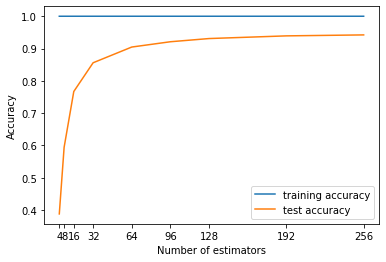

In [4]:
from src.helper.wrapper_random_projection import RandomProjectionWrapper
from sklearn.ensemble import RandomForestClassifier

training_accuracy = []
test_accuracy = []
proj_dim_range = [4, 8, 16, 32, 64, 96, 128, 192, 256]

for proj_dim in tqdm(proj_dim_range):
    # Build the model
    random_forest = RandomForestClassifier()
    proj_random_forest = RandomProjectionWrapper(random_forest, proj_dim=proj_dim)
    proj_random_forest = proj_random_forest.fit(X_train, y_train)
    # Record training set accuracy
    training_accuracy.append(proj_random_forest.score(X_train, y_train))
    # Record test set accuracy
    test_accuracy.append(proj_random_forest.score(X_test, y_test))

plt.plot(proj_dim_range, training_accuracy, label="training accuracy")
plt.plot(proj_dim_range, test_accuracy, label="test accuracy")
plt.xticks(proj_dim_range)
plt.ylabel("Accuracy")
plt.xlabel("Number of estimators")
plt.legend()
plt.savefig('proj_random_forest_acc_vs_estimators')

In [7]:
best_proj_dim = 64  # proj_dim_range[test_accuracy.index(max(test_accuracy))]

In [8]:
# Build the model
print(f'Build model with projection dimension {best_proj_dim}')
random_forest = RandomForestClassifier()
proj_random_forest = RandomProjectionWrapper(random_forest, proj_dim=best_proj_dim)
proj_random_forest = proj_random_forest.fit(X_train, y_train)

# Predict test and train data
accuracy = {}
accuracy["train"] = proj_random_forest.score(X_train, y_train)
accuracy["test"] = proj_random_forest.score(X_test, y_test)
print(f'Train accuracy: {accuracy["train"]:.4f}')
print(f'Test accuracy: {accuracy["test"]:.4f}')

# Predict test data
pred_mnist_prob = proj_random_forest.predict_proba(X_test)
y_pred = np.argmax(pred_mnist_prob, axis=1)

Build model with projection dimension 64
Train accuracy: 1.0000
Test accuracy: 0.9090


### Inspect classification result

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.91      0.89      0.90      1032
           3       0.88      0.89      0.88      1010
           4       0.89      0.90      0.90       982
           5       0.87      0.89      0.88       892
           6       0.93      0.93      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.88      0.86      0.87       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

